## Model 3 - EFR

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# check if GPU working 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# switch off cudnn 
torch.backends.cudnn.enabled = False

print(device)


cuda


In [19]:

class EFR_CNN(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, input_size, hidden_size, num_layers, mlp_hidden_size, output_size):
        super(EFR_CNN, self).__init__()
        """
        ERC-CNN Module combining CNN, BiLSTM, and MLP
        Input shape: (batch_size, in_channels, width, length)
        Output shape: (batch_size, seq_length, output_size)
        """
        # CNN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, 1))

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # MLP layers
        self.fc1 = nn.Linear(hidden_size * 2, mlp_hidden_size)
        self.fc2 = nn.Linear(mlp_hidden_size, output_size)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        # BiLSTM
        x = x.squeeze(1)  # Remove the singleton dimension
        x, _ = self.bilstm(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_emotions = 7


# Create individual components
# Initialize the ERC_CNN class
model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)


# Forward pass through the model
output = model(input_tensor)  # Add batch dimension

print("Final Output shape:", output.shape)

Final Output shape: torch.Size([1, 24, 7])


In [20]:

class MyDataset(Dataset):
    def __init__(self, json_path = 'train_file.json'):
        self.embedding_model = SentenceTransformer('all-mpnet-base-v2')
        self.train_data = pd.read_json(json_path)

    def generate_cnn_embeddings(self, row):
        speakers = row['speakers']

        embeddings_list = self.embedding_model.encode(row['utterances'])

        speaker_index = {}
        index = 0
        for speaker in speakers:
            if speaker not in speaker_index:
                speaker_index[speaker] = index
                index += 1

        S = len(speaker_index)
        N = len(speakers)
        embeddings_tensor = np.zeros((max(10 , S), N, 768))
        for i, (speaker, embedding) in enumerate(zip(speakers, embeddings_list)):
            idx = speaker_index[speaker]
            embeddings_tensor[idx, i, :] = embedding
        return embeddings_tensor

    def gen_trigger_matrix(self, row):
        triggers = row['triggers']
        trigger_matrix = np.zeros((len(triggers), 2))
        for idx, trigger in enumerate(triggers):
            if trigger is None:
                trigger = 0
            trigger_matrix[idx][int(trigger)] = 1
        return trigger_matrix


    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        X = self.generate_cnn_embeddings(self.train_data.iloc[idx])
        Y = self.gen_trigger_matrix(self.train_data.iloc[idx])
        # print(X.shape, Y.shape)
        return X, Y

In [21]:
# Define parameters
batch_size = 1
speakers = 10  # max_speakers
num_utterances = 24  # dialogue_length
embedding_size = 768

cnn_mid_channels = 3
cnn_out_channels = 1

hidden_lstm = 64
layers_lstm = 1

inputs_mlp = hidden_lstm * 2
hidden_mlp = 64
output_mlp = number_of_triggers = 2


# Initialize the ERC_CNN class
model = EFR_CNN(in_channels=speakers,
                mid_channels=cnn_mid_channels,
                out_channels=cnn_out_channels,
                input_size=embedding_size,
                hidden_size=hidden_lstm,
                num_layers=layers_lstm,
                mlp_hidden_size=hidden_mlp,
                output_size=output_mlp)

# input_tensor = torch.randn(batch_size, speakers, num_utterances, embedding_size)

In [22]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [23]:
folder_path = "/content/drive/MyDrive/IIITD/Courses/nlp/Assignment 4/"
folder_path = ""

path_train_file = "train_file.json"
path_val_file = "val_file.json"

dataset = MyDataset(path_train_file)
val_dataset = MyDataset(path_val_file)

criterion = nn.CrossEntropyLoss().to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# ADD TO DEVICE

model.to(DEVICE)


EFR_CNN(
  (conv1): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (bilstm): LSTM(768, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [24]:
import os 

train_losses , val_losses = [], []

if os.path.exists(folder_path + 'EFR_CNN.pth'):
    model.load_state_dict(torch.load(folder_path + 'EFR_CNN.pth'))
    print("Model Loaded")

else : 

    model.train()

    from tqdm import tqdm
    num_epochs = 6
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs.float())

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Print statistics
            running_loss += loss.item() * inputs.size(0)

            # tqdm.write(f"Training in Progress: {i+1}/{6000}")

        # Print average loss for the epoch
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

        train_losses.append(epoch_loss)

        running_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(val_data_loader)):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs.float())

            # Compute the loss
            loss = criterion(outputs, labels)

            # Print statistics
            running_loss += loss.item() * inputs.size(0)

            # tqdm.write(f"Training in Progress: {i+1}/{6000}")

        # Print average loss for the epoch
        epoch_loss = running_loss / len(val_dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {epoch_loss:.4f}")

        val_losses.append(epoch_loss)

        if epoch % 2 == 0:
            torch.save(model.state_dict(), folder_path + f'3_EFR_CNN_{epoch}.pth')

6740it [01:55, 58.34it/s]


Epoch [1/6], Train Loss: 9.5444


843it [00:12, 68.88it/s]


Epoch [1/6], Val Loss: 9.3888


6740it [01:55, 58.35it/s]


Epoch [2/6], Train Loss: 9.4986


843it [00:12, 69.11it/s]


Epoch [2/6], Val Loss: 9.3907


6740it [01:55, 58.44it/s]


Epoch [3/6], Train Loss: 9.4525


843it [00:12, 68.93it/s]


Epoch [3/6], Val Loss: 9.3327


6740it [01:55, 58.43it/s]


Epoch [4/6], Train Loss: 9.4012


843it [00:12, 69.00it/s]


Epoch [4/6], Val Loss: 9.3437


6740it [01:54, 58.62it/s]


Epoch [5/6], Train Loss: 9.3100


843it [00:12, 69.37it/s]


Epoch [5/6], Val Loss: 9.3112


6740it [01:55, 58.34it/s]


Epoch [6/6], Train Loss: 9.2491


843it [00:12, 69.18it/s]

Epoch [6/6], Val Loss: 9.3058


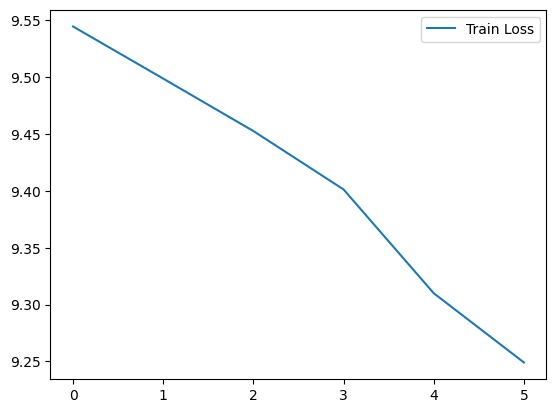

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
#plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()


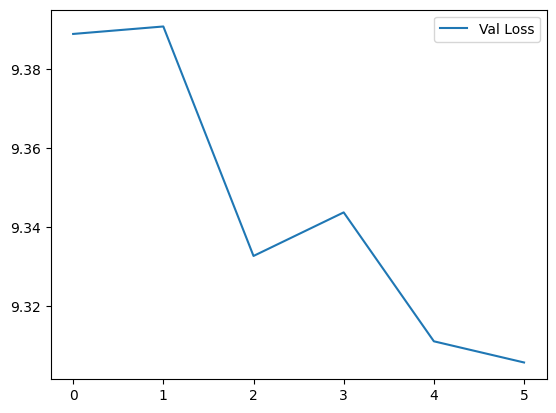

In [26]:
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()


In [27]:
# save the model
torch.save(model.state_dict(), folder_path + "m3.pth")
print("Model saved successfully")

Model saved successfully


In [28]:
model.load_state_dict(torch.load(folder_path + 'm3.pth'))
model.eval()

for i, (inputs, labels) in tqdm(enumerate(val_data_loader)):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    output = model(inputs.float())
    print(output)
    print(labels)
    break 

0it [00:00, ?it/s]

tensor([[[ 4.2558, -4.1753],
         [ 4.1332, -2.5353],
         [ 4.1924, -2.3245],
         [ 4.1824, -2.8571],
         [ 4.2545, -1.8767],
         [ 4.1043, -1.4154],
         [ 4.2395, -2.6628],
         [ 4.2099, -2.0659],
         [ 4.2383, -2.6046],
         [ 4.2073, -1.6972],
         [ 4.1704, -0.6314],
         [ 4.0906, -0.4181],
         [ 4.1798, -1.0118],
         [ 4.2917, -1.2388],
         [ 3.9106,  1.8136],
         [ 3.6612,  1.3674],
         [ 3.6697,  2.3236]]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.]]], device='cuda:0', dtype=torch.float64)


In [29]:
from sklearn.metrics import f1_score, confusion_matrix

model.load_state_dict(torch.load('m3.pth'))
model.to(DEVICE)
model.eval()

def get_F1(data_loader , model): 
    predictions = []
    true_labels = []
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels[:, :, 1].type(torch.LongTensor).to(DEVICE)
        outputs = model(inputs.float())
        pred = outputs.argmax(dim=-1)
        predictions.extend(pred.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())
    print("F1 Score: ", f1_score(true_labels, predictions, average='macro'))
    confusion_matrix(true_labels, predictions)

    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(confusion_matrix(true_labels, predictions), annot=True , fmt = 'd')
    plt.title("0-> No Trigger, 1-> Trigger")

    # add labels for predicted and true values
    plt.xlabel('Predicted')

    plt.ylabel('True')

    
    plt.show()


100%|██████████| 6740/6740 [01:37<00:00, 69.05it/s]


F1 Score:  0.5829718756921273


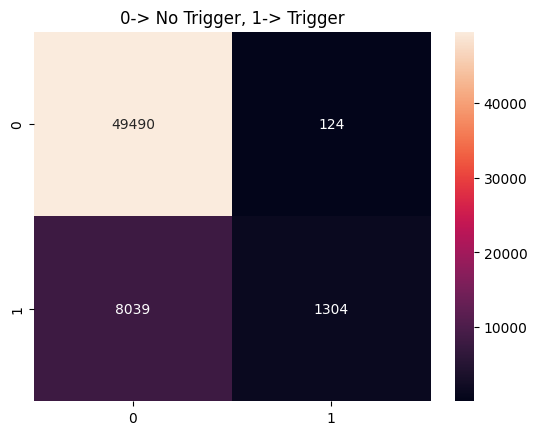

In [30]:
# TRAIN 

get_F1(dataloader, model)

100%|██████████| 843/843 [00:12<00:00, 68.56it/s]


F1 Score:  0.5813509828901917


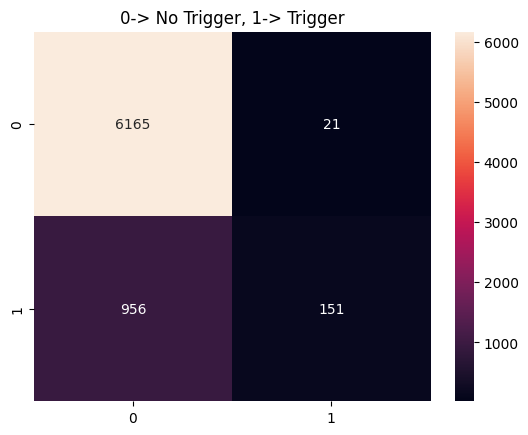

In [31]:
# VALIDATION 

get_F1(val_data_loader, model)